In [80]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist, mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import Model

In [70]:
os.makedirs('results', exist_ok=True)

In [81]:
# Imbalanced MNIST
def preprocess(dataset, imbalance_factor=0.01):

    ((X_train, Y_train), (X_test, Y_test)) = dataset.load_data()
    X_train_reshaped = X_train.reshape(len(X_train), -1)   
    X_test_reshaped = X_test.reshape(len(X_test), -1)

    X_train_norm = X_train_reshaped / 255            
    X_test_norm = X_test_reshaped / 255

    n_features = X_train_norm.shape[1]
    n_classes = 10

    print('Number of input features (image pixels) : ', n_features)
    print('Number of target classes (fashion categories) : ', n_classes)

    Y_train_onehot = to_categorical(Y_train, num_classes=n_classes)
    Y_test_onehot = to_categorical(Y_test, num_classes=n_classes)

    class_1_indices = np.where(Y_train == 1)[0]
    class_2_indices = np.where(Y_train == 2)[0]
    class_3_indices = np.where(Y_train == 3)[0]
    
    class_1_sampled = np.random.choice(class_1_indices, int(len(class_1_indices) * imbalance_factor), replace=False)
    class_2_sampled = np.random.choice(class_2_indices, int(len(class_2_indices) * imbalance_factor), replace=False)
    class_3_sampled = np.random.choice(class_3_indices, int(len(class_3_indices) * imbalance_factor), replace=False)

    other_classes_indices = np.where((Y_train != 1) & (Y_train != 2) & (Y_train != 3))[0]
    selected_indices = np.concatenate([class_1_sampled, class_2_sampled,class_3_sampled, other_classes_indices])

    X_train_imbalance = X_train_norm[selected_indices]
    Y_train_imbalance = Y_train_onehot[selected_indices]

    X_train_final, X_valid, Y_train_final, Y_valid = train_test_split(
        X_train_imbalance, Y_train_imbalance, test_size=0.25, stratify=Y_train_imbalance
    )

    return (n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm, X_train_norm)



def train(n_features, n_classes, model_name):
    model = Sequential()
    model.add(Dense(1000, input_dim = n_features, activation='relu', use_bias=False))

    model.add(Dense(200, activation='relu', use_bias=False))
    model.add(Dense(n_classes, activation='softmax', use_bias=False))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
    model.summary()
    save_at = str(model_name)
    save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, 
                             save_best_only=True, save_weights_only=False, mode='max')
    return (model,save_best)


def train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best):
    history = model.fit( X_train_final, Y_train_final, 
                        epochs = 10, batch_size = 20, 
                        callbacks=[save_best], verbose=1, 
                        validation_data = (X_valid, Y_valid) )

    plt.figure(figsize=(6, 5))
    plt.plot(history.history['accuracy'], color='r')
    plt.plot(history.history['val_accuracy'], color='b')
    plt.title('Model Accuracy', weight='bold', fontsize=16)
    plt.ylabel('accuracy', weight='bold', fontsize=14)
    plt.xlabel('epoch', weight='bold', fontsize=14)
    plt.ylim(0.5, 1)
    plt.xticks(weight='bold', fontsize=12)
    plt.yticks(weight='bold', fontsize=12)
    plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
    plt.grid(color = 'y', linewidth='0.5')
    plt.show()


def test(model, X_test_norm, Y_test_onehot):
    score = model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
    print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')
    Y_pred = np.round(model.predict(X_test_norm))

In [82]:
# pruning%
K = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

def weigh_pruning(X_test_norm, Y_test_onehot, K, trained_model, model_load):

    total_no_layers = len(trained_model.layers)

    all_weights = {}

    for layer_no in range(total_no_layers - 1):
        layer_weights = (pd.DataFrame(trained_model.layers[layer_no].get_weights()[0]).stack()).to_dict() 
        layer_weights = { (layer_no, k[0], k[1]): v for k, v in layer_weights.items() }
        all_weights.update(layer_weights)
    
    all_weights_sorted = {k: v for k, v in sorted(all_weights.items(), key=lambda item: abs(item[1]))}
    total_no_weights = len(all_weights_sorted) 
    # print(total_no_weights)
    print('all_weights',len(all_weights))
    weight_pruning_scores = []

    for pruning_percent in K:

        new_model = load_model(model_load)
        new_weights = trained_model.get_weights().copy()

        prune_fraction = pruning_percent/100
        number_of_weights_to_be_pruned = int(prune_fraction*total_no_weights)
        weights_to_be_pruned = {k: all_weights_sorted[k] for k in list(all_weights_sorted)[ :  number_of_weights_to_be_pruned]}     

        for k, v in weights_to_be_pruned.items():
            new_weights[k[0]][k[1], k[2]] = 0

        for layer_no in range(total_no_layers - 1) :
            new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
            new_model.layers[layer_no].set_weights(new_layer_weights)
        
        new_score  = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
        weight_pruning_scores .append(new_score[1])
    return weight_pruning_scores


def neuron_pruning(X_test_norm, Y_test_onehot, total_no_layers, trained_model, model_load):

    all_neurons = {}

    for layer_no in range(total_no_layers - 1):         

        layer_neurons = {}
        layer_neurons_df = pd.DataFrame(trained_model.layers[layer_no].get_weights()[0])

        for i in range(len(layer_neurons_df.columns)):
            layer_neurons.update({ i : np.array( layer_neurons_df.iloc[:,i] ) })    
                                                                    
        layer_neurons = { (layer_no, k): v for k, v in layer_neurons.items() }
        all_neurons.update(layer_neurons)
    
    all_neurons_sorted = {k: v for k, v in sorted(all_neurons.items(), key=lambda item: np.linalg.norm(item[1], ord=2, axis=0))}
    total_no_neurons = len(all_neurons_sorted) 
    # print(total_no_neurons)

    neuron_pruning_scores = []

    for pruning_percent in K:

        new_model = load_model(model_load)
        new_weights = trained_model.get_weights().copy()

        prune_fraction = pruning_percent/100
        number_of_neurons_to_be_pruned = int(prune_fraction*total_no_neurons)
        neurons_to_be_pruned = {k: all_neurons_sorted[k] for k in list(all_neurons_sorted)[ : number_of_neurons_to_be_pruned]}     

        for k, v in neurons_to_be_pruned.items():
            new_weights[k[0]][:, k[1]] = 0

        for layer_no in range(total_no_layers - 1) :
            new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
            new_model.layers[layer_no].set_weights(new_layer_weights)
        
        new_score  = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
        neuron_pruning_scores.append(new_score[1])
    return neuron_pruning_scores

In [83]:
# nc  + std
def compute_gradient_Sw(X_train_norm, Y_train_onehot, trained_model):
    """
    Compute the gradient of the within-class scatter matrix (S_w) for each layer.
    """
    N = X_train_norm.shape[0] 
    output_dim = trained_model.layers[-1].output_shape[1]  
    
    gradient_Sw = {}
    all_weights = {}

    for layer_no, layer in enumerate(trained_model.layers[:-1]):

        layer_model = Model(inputs=trained_model.input, outputs=layer.output)
        H_layer = layer_model.predict(X_train_norm)
        print(f"Layer {layer_no} activation shape: {H_layer.shape}")

        mu_c = np.zeros((output_dim, H_layer.shape[1]))
        for c in range(output_dim):
            class_samples = H_layer[Y_train_onehot[:, c] == 1]
            mu_c[c] = np.mean(class_samples, axis=0)

        W = layer.get_weights()[0]  
        grad_Sw = np.zeros_like(W)

        for i in range(N):
            for c in range(output_dim):
                if Y_train_onehot[i, c] == 1:
                    diff = H_layer[i] - mu_c[c]
                    diff_projected = np.dot(diff, W.T) 
                    grad_Sw += 2 * np.outer(diff_projected, diff) 

        gradient_Sw[layer_no] = grad_Sw
    return gradient_Sw


def prune_weights_using_Sw(X_test_norm, Y_test_onehot, X_train_norm, Y_train_onehot, K, trained_model, model_load):
    """
    Perform weight pruning using the gradient of the within-class scatter matrix (S_w),
    and rank the weights based on Neural Collapse scores.
    """
    gradient_Sw = compute_gradient_Sw(X_train_norm, Y_train_onehot, trained_model)
    total_no_layers = len(trained_model.layers)
    weight_pruning_scores = []

    all_weights = {}
    all_ranking_scores = {}

    for layer_no in range(total_no_layers - 1):
        if layer_no not in gradient_Sw:
            print(f"Warning: No gradient found for layer {layer_no}. Skipping this layer.")
            continue

        grad_Sw = gradient_Sw[layer_no]
        print(f"Layer {layer_no}: Gradient shape: {grad_Sw.shape}")

        weight_importance = np.linalg.norm(grad_Sw, ord=2)
        
        W = trained_model.layers[layer_no].get_weights()[0] 
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                all_weights[(layer_no, i, j)] = W[i, j]
                all_ranking_scores[(layer_no, i, j)] = np.abs(grad_Sw[i, j])

    all_weights_sorted = {k: v for k, v in sorted(all_ranking_scores.items(), key=lambda item: item[1])}

    total_no_weights = len(all_weights_sorted)
    print(f"Total weights to consider: {total_no_weights}")

    for pruning_percent in K:
    
        new_model = load_model(model_load)
        new_weights = new_model.get_weights().copy()

        prune_fraction = pruning_percent / 100
        number_of_weights_to_be_pruned = int(prune_fraction * total_no_weights)
        weights_to_be_pruned = list(all_weights_sorted.keys())[:number_of_weights_to_be_pruned]

        for k in weights_to_be_pruned:
            layer_no, i, j = k
            new_weights[layer_no][i, j] = 0

        for layer_no in range(total_no_layers - 1):
            new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
            new_model.layers[layer_no].set_weights(new_layer_weights)

        new_score = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
        weight_pruning_scores.append((pruning_percent, new_score[1]))

    return weight_pruning_scores


In [ ]:
# def compute_gradient_Sw(X_test_norm, Y_test_onehot, trained_model):
#     """
#     Compute the gradient of the within-class scatter matrix (S_w) for each layer.
#     """
#     N = X_test_norm.shape[0] 
#     output_dim = trained_model.layers[-1].output_shape[1]  
    
#     gradient_Sw = {}

#     for layer_no, layer in enumerate(trained_model.layers[:-1]):
#         layer_model = Model(inputs=trained_model.input, outputs=layer.output)
#         H_layer = layer_model.predict(X_test_norm)
#         print(f"Layer {layer_no} activation shape: {H_layer.shape}")

#         # Initialize mean for each class
#         mu_c = np.zeros((output_dim, H_layer.shape[1]))
#         for c in range(output_dim):
#             class_samples = H_layer[Y_test_onehot[:, c] == 1]
#             mu_c[c] = np.mean(class_samples, axis=0)

#         W = layer.get_weights()[0]  # Get the weight matrix for the layer
#         grad_Sw = np.zeros_like(W)

#         # Compute the gradient of S_w for the current layer
#         for i in range(N):
#             for c in range(output_dim):
#                 if Y_test_onehot[i, c] == 1:
#                     # Activation for the sample
#                     h_i = H_layer[i]
#                     # Compute the gradient term (h_i - mu_c) * x_i^T
#                     diff = h_i - mu_c[c]
#                     x_i = X_test_norm[i]
#                     print('xi',x_i.shape)
#                     print('diff',diff.shape)
#                     grad_Sw += 2 * np.outer(diff, x_i)

#         gradient_Sw[layer_no] = grad_Sw
#     return gradient_Sw


# def prune_weights_using_Sw(X_test_norm, Y_test_onehot, K, trained_model, model_load):
#     """
#     Perform weight pruning using the gradient of the within-class scatter matrix (S_w),
#     and rank the weights based on Neural Collapse scores.
#     """
#     gradient_Sw = compute_gradient_Sw(X_test_norm, Y_test_onehot, trained_model)
#     total_no_layers = len(trained_model.layers)
#     weight_pruning_scores = []

#     all_weights = {}
#     all_ranking_scores = {}

#     for layer_no in range(total_no_layers - 1):
#         if layer_no not in gradient_Sw:
#             print(f"Warning: No gradient found for layer {layer_no}. Skipping this layer.")
#             continue

#         grad_Sw = gradient_Sw[layer_no]
#         print(grad_Sw)
#         print(f"Layer {layer_no}: Gradient shape: {grad_Sw.shape}")

#         weight_importance = np.linalg.norm(grad_Sw, ord=2)
        
#         W = trained_model.layers[layer_no].get_weights()[0]  
#         for i in range(W.shape[0]):
#             for j in range(W.shape[1]):
#                 all_weights[(layer_no, i, j)] = W[i, j]
#                 all_ranking_scores[(layer_no, i, j)] = np.abs(grad_Sw[i, j])

#     all_weights_sorted = {k: v for k, v in sorted(all_ranking_scores.items(), key=lambda item: item[1])}

#     total_no_weights = len(all_weights_sorted)
#     print(f"Total weights to consider: {total_no_weights}")

#     for pruning_percent in K:
#         new_model = load_model(model_load)
#         new_weights = new_model.get_weights().copy()

#         prune_fraction = pruning_percent / 100
#         number_of_weights_to_be_pruned = int(prune_fraction * total_no_weights)

#         weights_to_be_pruned = list(all_weights_sorted.keys())[:number_of_weights_to_be_pruned]

#         for k in weights_to_be_pruned:
#             layer_no, i, j = k
#             new_weights[layer_no][i, j] = 0

#         for layer_no in range(total_no_layers - 1):
#             new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
#             new_model.layers[layer_no].set_weights(new_layer_weights)

#         new_score = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
#         weight_pruning_scores.append((pruning_percent, new_score[1]))

#     return weight_pruning_scores


In [84]:
def plots(standard_w, standard__neuron, nc, imbalance):
    plt.figure(figsize=(8, 4))
    plt.plot(pd.DataFrame(standard_w).set_index(pd.Series(K), drop=True), color='r')
    plt.plot(pd.DataFrame(standard__neuron).set_index(pd.Series(K), drop=True), color='g')
    plt.plot(pd.DataFrame(nc).set_index(pd.Series(K), drop=True), color='b')
    plt.title('Effect of Pruning on Accuracy (Imbalance = ' + imbalance + ')', fontsize=10)
    plt.ylabel('Score', fontsize=8)
    plt.xlabel('Pruning Percentage', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=8)
    plt.ylim(0, 1)
    plt.legend(['standard_w_pruning', 'standard_neuron_pruning', 'NC_pruning'], loc='best', prop={'size': 8})
    plt.grid(color='gray', linestyle='-', linewidth=0.3)
    filename = f"noisy/{imbalance}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

Number of input features (image pixels) :  784
Number of target classes (fashion categories) :  10


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 1000)              784000    
                                                                 
 dense_67 (Dense)            (None, 200)               200000    
                                                                 
 dense_68 (Dense)            (None, 10)                2000      
                                                                 
Total params: 986000 (3.76 MB)
Trainable params: 986000 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1548/1548 [==============================] - 4s 3ms/step - loss: 0.2867 - accuracy: 0.9249 - val_loss: 0.1619 - val_accuracy: 0.9500
Epoch 2/10
  71/1548 [>.............................] - ETA: 3s - loss: 0.1531 - accuracy: 0.9606

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1548/1548 [==============================] - 4s 2ms/step - loss: 0.1167 - accuracy: 0.9659 - val_loss: 0.1029 - val_accuracy: 0.9702
Epoch 3/10
1548/1548 [==============================] - 4s 2ms/step - loss: 0.0758 - accuracy: 0.9776 - val_loss: 0.0861 - val_accuracy: 0.9747
Epoch 4/10
1548/1548 [==============================] - 4s 2ms/step - loss: 0.0535 - accuracy: 0.9836 - val_loss: 0.0781 - val_accuracy: 0.9764
Epoch 5/10
1548/1548 [==============================] - 3s 2ms/step - loss: 0.0389 - accuracy: 0.9889 - val_loss: 0.0755 - val_accuracy: 0.9777
Epoch 6/10
1548/1548 [==============================] - 3s 2ms/step - loss: 0.0265 - accuracy: 0.9927 - val_loss: 0.0718 - val_accuracy: 0.9802
Epoch 7/10
1548/1548 [==============================] - 3s 2ms/step - loss: 0.0196 - accuracy: 0.9946 - val_loss: 0.0662 - val_accuracy: 0.9812
Epoch 8/10
1548/1548 [==============================] - 4s 2ms/step - loss: 0.0132 - accuracy: 0.9968 - val_loss: 0.0663 - val_accuracy: 0.9820
Epo

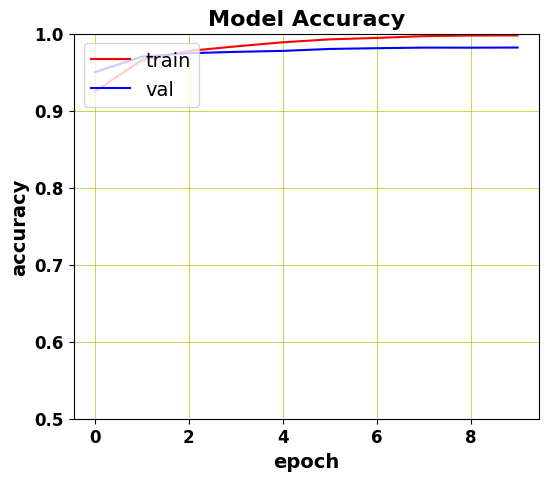

Accuracy over the test set: 
  84.85 %
1875/1875 [==============================] - 1s 534us/step
Layer 0 activation shape: (60000, 1000)
1875/1875 [==============================] - 2s 782us/step
Layer 1 activation shape: (60000, 200)
Layer 0: Gradient shape: (784, 1000)
Layer 1: Gradient shape: (1000, 200)
Total weights to consider: 984000
all_weights 984000


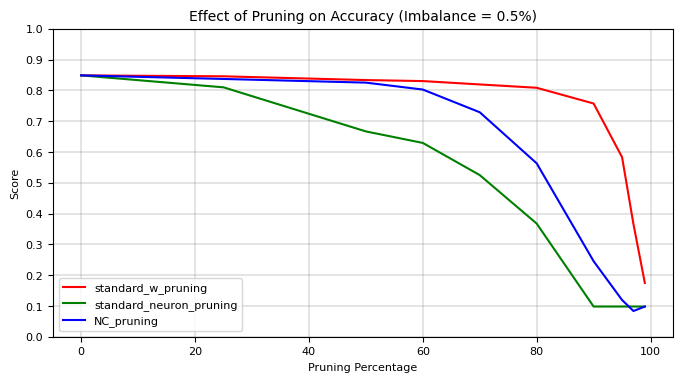

In [71]:
n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm,X_train_norm = preprocess(mnist,imbalance_factor=0.005)
model,save_best = train(n_features, n_classes, 'mnist.hdf5')
train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best)
test(model, X_test_norm, Y_test_onehot)
trained_model = load_model("mnist.hdf5")
total_no_layers = len(trained_model.layers)
neuron_pruning_scores = neuron_pruning(X_test_norm, Y_test_onehot, total_no_layers, trained_model, 'mnist.hdf5')
weight_pruning_scores_nc = prune_weights_using_Sw(X_test_norm, Y_test_onehot,X_train_norm, Y_train_onehot, K, trained_model, 'mnist.hdf5')
weight_pruning_scores = weigh_pruning(X_test_norm, Y_test_onehot, K, trained_model, 'mnist.hdf5')

plots(weight_pruning_scores,neuron_pruning_scores, list(map(lambda x: x[1], weight_pruning_scores_nc)),'0.5%')

Number of input features (image pixels) :  784
Number of target classes (fashion categories) :  10


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 1000)              784000    
                                                                 
 dense_70 (Dense)            (None, 200)               200000    
                                                                 
 dense_71 (Dense)            (None, 10)                2000      
                                                                 
Total params: 986000 (3.76 MB)
Trainable params: 986000 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1551/1551 [==============================] - 4s 2ms/step - loss: 0.2926 - accuracy: 0.9228 - val_loss: 0.1556 - val_accuracy: 0.9534
Epoch 2/10
  83/1551 [>.............................] - ETA: 2s - loss: 0.1357 - accuracy: 0.9614

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1551/1551 [==============================] - 3s 2ms/step - loss: 0.1178 - accuracy: 0.9661 - val_loss: 0.1122 - val_accuracy: 0.9675
Epoch 3/10
1551/1551 [==============================] - 3s 2ms/step - loss: 0.0786 - accuracy: 0.9769 - val_loss: 0.0932 - val_accuracy: 0.9725
Epoch 4/10
1551/1551 [==============================] - 3s 2ms/step - loss: 0.0548 - accuracy: 0.9842 - val_loss: 0.1191 - val_accuracy: 0.9631
Epoch 5/10
1551/1551 [==============================] - 3s 2ms/step - loss: 0.0410 - accuracy: 0.9883 - val_loss: 0.0752 - val_accuracy: 0.9790
Epoch 6/10
1551/1551 [==============================] - 3s 2ms/step - loss: 0.0281 - accuracy: 0.9926 - val_loss: 0.0817 - val_accuracy: 0.9768
Epoch 7/10
1551/1551 [==============================] - 3s 2ms/step - loss: 0.0207 - accuracy: 0.9953 - val_loss: 0.0712 - val_accuracy: 0.9797
Epoch 8/10
1551/1551 [==============================] - 3s 2ms/step - loss: 0.0153 - accuracy: 0.9964 - val_loss: 0.0725 - val_accuracy: 0.9808
Epo

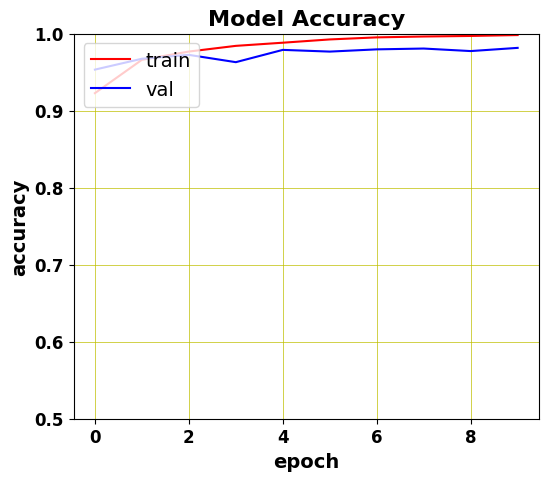

Accuracy over the test set: 
  87.91 %
1875/1875 [==============================] - 1s 568us/step
Layer 0 activation shape: (60000, 1000)
1875/1875 [==============================] - 2s 872us/step
Layer 1 activation shape: (60000, 200)
Layer 0: Gradient shape: (784, 1000)
Layer 1: Gradient shape: (1000, 200)
Total weights to consider: 984000
all_weights 984000


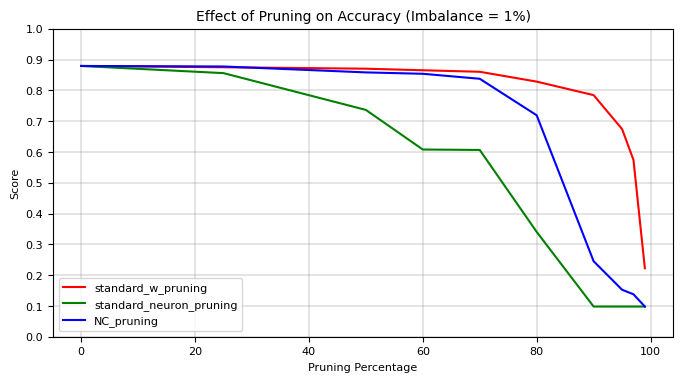

In [72]:
n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm,X_train_norm = preprocess(mnist,imbalance_factor=0.01)
model,save_best = train(n_features, n_classes, 'mnist.hdf5')
train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best)
test(model, X_test_norm, Y_test_onehot)
trained_model = load_model("mnist.hdf5")
total_no_layers = len(trained_model.layers)
neuron_pruning_scores = neuron_pruning(X_test_norm, Y_test_onehot, total_no_layers, trained_model, 'mnist.hdf5')
weight_pruning_scores_nc = prune_weights_using_Sw(X_test_norm, Y_test_onehot,X_train_norm, Y_train_onehot, K, trained_model, 'mnist.hdf5')
weight_pruning_scores = weigh_pruning(X_test_norm, Y_test_onehot, K, trained_model, 'mnist.hdf5')

plots(weight_pruning_scores,neuron_pruning_scores, list(map(lambda x: x[1], weight_pruning_scores_nc)),'1%')

Number of input features (image pixels) :  784
Number of target classes (fashion categories) :  10


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 1000)              784000    
                                                                 
 dense_73 (Dense)            (None, 200)               200000    
                                                                 
 dense_74 (Dense)            (None, 10)                2000      
                                                                 
Total params: 986000 (3.76 MB)
Trainable params: 986000 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1580/1580 [==============================] - 5s 3ms/step - loss: 0.3179 - accuracy: 0.9138 - val_loss: 0.1706 - val_accuracy: 0.9494
Epoch 2/10
  64/1580 [>.............................] - ETA: 3s - loss: 0.1415 - accuracy: 0.9539

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1580/1580 [==============================] - 6s 3ms/step - loss: 0.1255 - accuracy: 0.9635 - val_loss: 0.1359 - val_accuracy: 0.9593
Epoch 3/10
1580/1580 [==============================] - 6s 4ms/step - loss: 0.0840 - accuracy: 0.9752 - val_loss: 0.1020 - val_accuracy: 0.9709
Epoch 4/10
1580/1580 [==============================] - 5s 3ms/step - loss: 0.0594 - accuracy: 0.9839 - val_loss: 0.0920 - val_accuracy: 0.9732
Epoch 5/10
1580/1580 [==============================] - 5s 3ms/step - loss: 0.0420 - accuracy: 0.9883 - val_loss: 0.0866 - val_accuracy: 0.9744
Epoch 6/10
1580/1580 [==============================] - 4s 3ms/step - loss: 0.0302 - accuracy: 0.9923 - val_loss: 0.0845 - val_accuracy: 0.9749
Epoch 7/10
1580/1580 [==============================] - 4s 3ms/step - loss: 0.0222 - accuracy: 0.9949 - val_loss: 0.0846 - val_accuracy: 0.9751
Epoch 8/10
1580/1580 [==============================] - 5s 3ms/step - loss: 0.0160 - accuracy: 0.9964 - val_loss: 0.0849 - val_accuracy: 0.9756
Epo

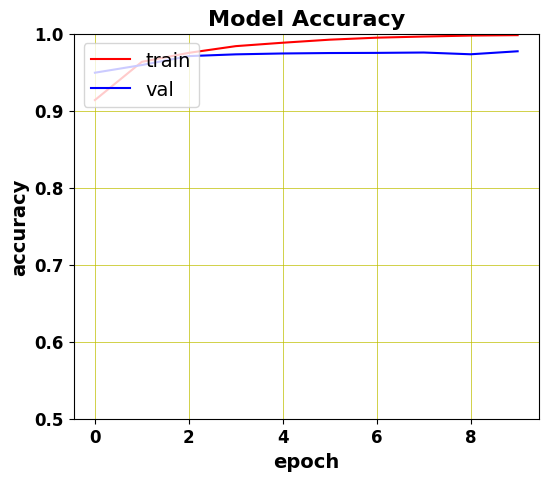

Accuracy over the test set: 
  95.1 %
1875/1875 [==============================] - 2s 845us/step
Layer 0 activation shape: (60000, 1000)
1875/1875 [==============================] - 2s 940us/step
Layer 1 activation shape: (60000, 200)
Layer 0: Gradient shape: (784, 1000)
Layer 1: Gradient shape: (1000, 200)
Total weights to consider: 984000
all_weights 984000


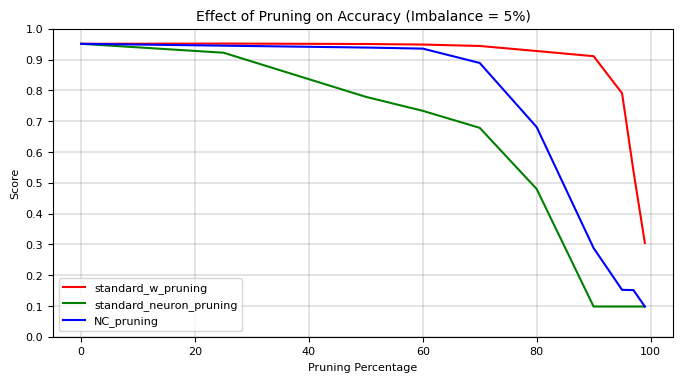

In [73]:
n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm,X_train_norm = preprocess(mnist,imbalance_factor=0.05)
model,save_best = train(n_features, n_classes, 'mnist.hdf5')
train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best)
test(model, X_test_norm, Y_test_onehot)
trained_model = load_model("mnist.hdf5")
total_no_layers = len(trained_model.layers)
neuron_pruning_scores = neuron_pruning(X_test_norm, Y_test_onehot, total_no_layers, trained_model, 'mnist.hdf5')
weight_pruning_scores_nc = prune_weights_using_Sw(X_test_norm, Y_test_onehot,X_train_norm, Y_train_onehot, K, trained_model, 'mnist.hdf5')
weight_pruning_scores = weigh_pruning(X_test_norm, Y_test_onehot, K, trained_model, 'mnist.hdf5')

plots(weight_pruning_scores,neuron_pruning_scores, list(map(lambda x: x[1], weight_pruning_scores_nc)),'5%')

Number of input features (image pixels) :  784
Number of target classes (fashion categories) :  10


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 1000)              784000    
                                                                 
 dense_76 (Dense)            (None, 200)               200000    
                                                                 
 dense_77 (Dense)            (None, 10)                2000      
                                                                 
Total params: 986000 (3.76 MB)
Trainable params: 986000 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1615/1615 [==============================] - 5s 3ms/step - loss: 0.3290 - accuracy: 0.9106 - val_loss: 0.1796 - val_accuracy: 0.9499
Epoch 2/10
  65/1615 [>.............................] - ETA: 3s - loss: 0.1463 - accuracy: 0.9577

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1615/1615 [==============================] - 5s 3ms/step - loss: 0.1317 - accuracy: 0.9620 - val_loss: 0.1403 - val_accuracy: 0.9596
Epoch 3/10
1615/1615 [==============================] - 5s 3ms/step - loss: 0.0897 - accuracy: 0.9745 - val_loss: 0.1061 - val_accuracy: 0.9686
Epoch 4/10
1615/1615 [==============================] - 5s 3ms/step - loss: 0.0637 - accuracy: 0.9822 - val_loss: 0.0987 - val_accuracy: 0.9701
Epoch 5/10
1615/1615 [==============================] - 5s 3ms/step - loss: 0.0463 - accuracy: 0.9867 - val_loss: 0.0912 - val_accuracy: 0.9738
Epoch 6/10
1615/1615 [==============================] - 6s 4ms/step - loss: 0.0353 - accuracy: 0.9903 - val_loss: 0.0798 - val_accuracy: 0.9779
Epoch 7/10
1615/1615 [==============================] - 5s 3ms/step - loss: 0.0256 - accuracy: 0.9936 - val_loss: 0.0819 - val_accuracy: 0.9772
Epoch 8/10
1615/1615 [==============================] - 5s 3ms/step - loss: 0.0196 - accuracy: 0.9951 - val_loss: 0.0783 - val_accuracy: 0.9788
Epo

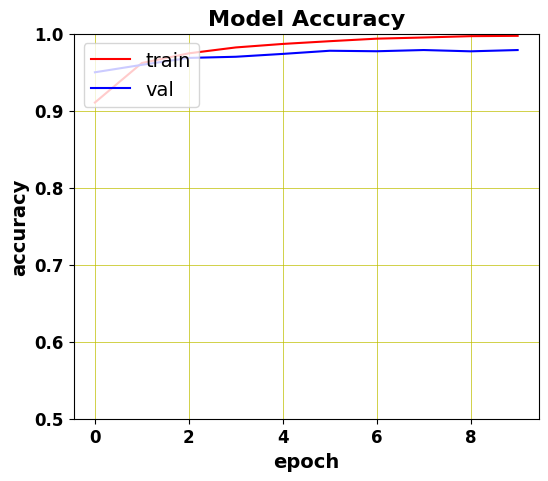

Accuracy over the test set: 
  96.43 %
1875/1875 [==============================] - 2s 866us/step
Layer 0 activation shape: (60000, 1000)
1875/1875 [==============================] - 2s 1ms/step
Layer 1 activation shape: (60000, 200)
Layer 0: Gradient shape: (784, 1000)
Layer 1: Gradient shape: (1000, 200)
Total weights to consider: 984000
all_weights 984000


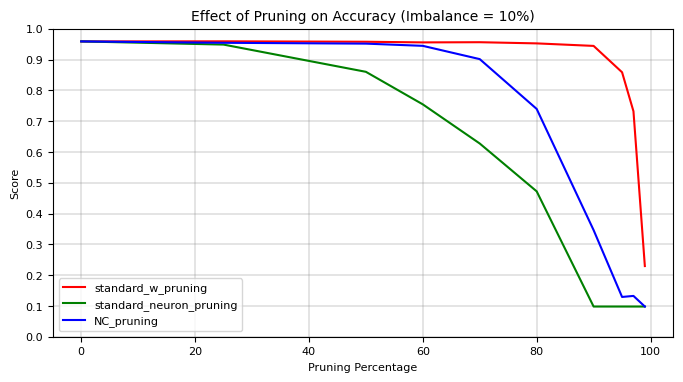

In [74]:
n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm,X_train_norm = preprocess(mnist,imbalance_factor=0.1)
model,save_best = train(n_features, n_classes, 'mnist.hdf5')
train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best)
test(model, X_test_norm, Y_test_onehot)
trained_model = load_model("mnist.hdf5")
total_no_layers = len(trained_model.layers)
neuron_pruning_scores = neuron_pruning(X_test_norm, Y_test_onehot, total_no_layers, trained_model, 'mnist.hdf5')
weight_pruning_scores_nc = prune_weights_using_Sw(X_test_norm, Y_test_onehot,X_train_norm, Y_train_onehot, K, trained_model, 'mnist.hdf5')
weight_pruning_scores = weigh_pruning(X_test_norm, Y_test_onehot, K, trained_model, 'mnist.hdf5')

plots(weight_pruning_scores,neuron_pruning_scores, list(map(lambda x: x[1], weight_pruning_scores_nc)),'10%')

#noisy data

In [85]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

def noise(dataset, noise_factor=0.5):
    ((X_train, Y_train), (X_test, Y_test)) = dataset.load_data()
    
    # Reshape the data
    X_train_reshaped = X_train.reshape(len(X_train), -1)   
    X_test_reshaped = X_test.reshape(len(X_test), -1)

    # Normalize the images by dividing by 255
    X_train_norm = X_train_reshaped / 255            
    X_test_norm = X_test_reshaped / 255

    # Add Gaussian noise to the data
    noise_train = np.random.normal(0, noise_factor, X_train_norm.shape)
    noise_test = np.random.normal(0, noise_factor, X_test_norm.shape)
    
    X_train_noisy = X_train_norm + noise_train
    X_test_noisy = X_test_norm + noise_test

    # Ensure pixel values remain between 0 and 1
    X_train_noisy = np.clip(X_train_noisy, 0, 1)
    X_test_noisy = np.clip(X_test_noisy, 0, 1)

    # Get the number of features and classes
    n_features = X_train_noisy.shape[1]
    n_classes = 10
    Y_train_onehot = to_categorical(Y_train, num_classes=n_classes)
    Y_test_onehot = to_categorical(Y_test, num_classes=n_classes)

    # Plot one random test sample and its noisy version separately
    random_index = np.random.randint(0, X_test_noisy.shape[0])
    actual_image = X_test[random_index].reshape(28, 28)
    noisy_image = X_test_noisy[random_index].reshape(28, 28)

    # Save the actual image
    # plt.figure(figsize=(5, 5))
    # plt.imshow(actual_image, cmap='gray')
    # plt.axis('off')
    # actual_image_path = f"{save_dir}actual_image_{random_index}.png"
    # plt.savefig(actual_image_path)
    # plt.close()  # Close the figure to prevent memory overflow

    # # Save the noisy image
    # plt.figure(figsize=(5, 5))
    # plt.imshow(noisy_image, cmap='gray')
    # plt.axis('off')
    # noisy_image_path = f"{save_dir}noisy_image_{random_index}.png"
    # plt.savefig(noisy_image_path)
    # plt.close()  # Close the figure to prevent memory overflow

    # print(f"Images saved: {actual_image_path}, {noisy_image_path}")
    return X_test_noisy, Y_test_onehot

# Example usage
# X_test_noisy, Y_test_onehot = noise(mnist)


Number of input features (image pixels) :  784
Number of target classes (fashion categories) :  10


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 1000)              784000    
                                                                 
 dense_55 (Dense)            (None, 200)               200000    
                                                                 
 dense_56 (Dense)            (None, 10)                2000      
                                                                 
Total params: 986000 (3.76 MB)
Trainable params: 986000 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1548/1548 [==============================] - 4s 2ms/step - loss: 0.2871 - accuracy: 0.9224 - val_loss: 0.1520 - val_accuracy: 0.9576
Epoch 2/10
  69/1548 [>.............................] - ETA: 3s - loss: 0.1155 - accuracy: 0.9681

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1548/1548 [==============================] - 4s 2ms/step - loss: 0.1156 - accuracy: 0.9661 - val_loss: 0.1054 - val_accuracy: 0.9695
Epoch 3/10
1548/1548 [==============================] - 3s 2ms/step - loss: 0.0763 - accuracy: 0.9772 - val_loss: 0.0863 - val_accuracy: 0.9754
Epoch 4/10
1548/1548 [==============================] - 4s 2ms/step - loss: 0.0527 - accuracy: 0.9846 - val_loss: 0.0819 - val_accuracy: 0.9756
Epoch 5/10
1548/1548 [==============================] - 3s 2ms/step - loss: 0.0368 - accuracy: 0.9901 - val_loss: 0.0757 - val_accuracy: 0.9768
Epoch 6/10
1548/1548 [==============================] - 3s 2ms/step - loss: 0.0269 - accuracy: 0.9923 - val_loss: 0.0795 - val_accuracy: 0.9759
Epoch 7/10
1548/1548 [==============================] - 4s 2ms/step - loss: 0.0191 - accuracy: 0.9951 - val_loss: 0.0687 - val_accuracy: 0.9809
Epoch 8/10
1548/1548 [==============================] - 3s 2ms/step - loss: 0.0146 - accuracy: 0.9963 - val_loss: 0.0674 - val_accuracy: 0.9818
Epo

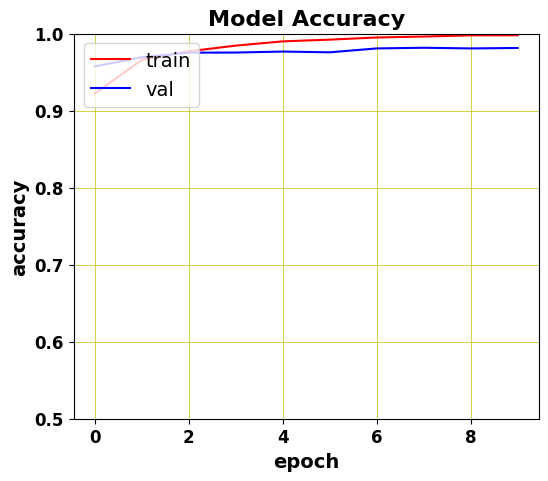

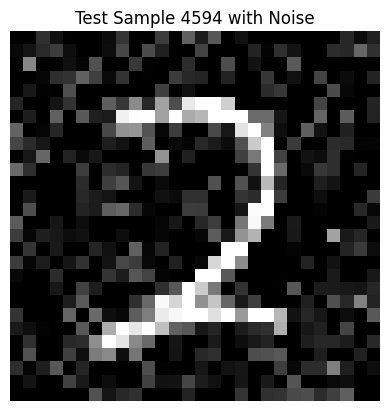

Accuracy over the test set: 
  66.76 %
1875/1875 [==============================] - 1s 554us/step
Layer 0 activation shape: (60000, 1000)
1875/1875 [==============================] - 2s 948us/step
Layer 1 activation shape: (60000, 200)
Layer 0: Gradient shape: (784, 1000)
Layer 1: Gradient shape: (1000, 200)
Total weights to consider: 984000
all_weights 984000


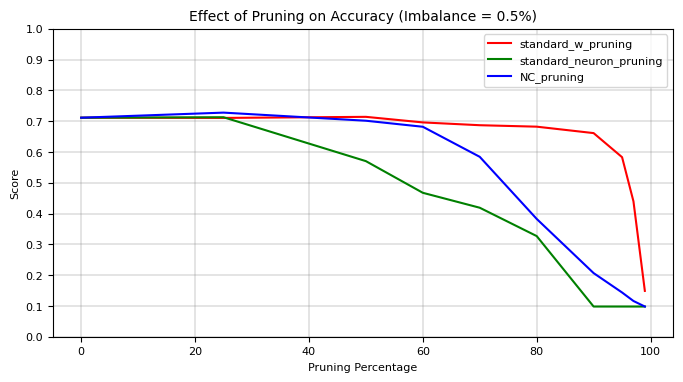

In [66]:
n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm,X_train_norm = preprocess(mnist,imbalance_factor=0.005)
model,save_best = train(n_features, n_classes, 'mnist.hdf5')
train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best)
X_test_noisy,Y_test_onehot = noise(mnist)
test(model, X_test_noisy, Y_test_onehot)
trained_model = load_model("mnist.hdf5")
total_no_layers = len(trained_model.layers)
neuron_pruning_scores = neuron_pruning(X_test_noisy, Y_test_onehot, total_no_layers, trained_model, 'mnist.hdf5')
weight_pruning_scores_nc = prune_weights_using_Sw(X_test_noisy, Y_test_onehot,X_train_norm, Y_train_onehot, K, trained_model, 'mnist.hdf5')
weight_pruning_scores = weigh_pruning(X_test_noisy, Y_test_onehot, K, trained_model, 'mnist.hdf5')

plots(weight_pruning_scores,neuron_pruning_scores, list(map(lambda x: x[1], weight_pruning_scores_nc)),'0.5%')

Number of input features (image pixels) :  784
Number of target classes (fashion categories) :  10


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 1000)              784000    
                                                                 
 dense_58 (Dense)            (None, 200)               200000    
                                                                 
 dense_59 (Dense)            (None, 10)                2000      
                                                                 
Total params: 986000 (3.76 MB)
Trainable params: 986000 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1551/1551 [==============================] - 4s 2ms/step - loss: 0.3018 - accuracy: 0.9187 - val_loss: 0.1418 - val_accuracy: 0.9572
Epoch 2/10
  80/1551 [>.............................] - ETA: 2s - loss: 0.1452 - accuracy: 0.9588

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1551/1551 [==============================] - 4s 2ms/step - loss: 0.1184 - accuracy: 0.9655 - val_loss: 0.0986 - val_accuracy: 0.9717
Epoch 3/10
1551/1551 [==============================] - 4s 2ms/step - loss: 0.0780 - accuracy: 0.9777 - val_loss: 0.0829 - val_accuracy: 0.9741
Epoch 4/10
1551/1551 [==============================] - 4s 2ms/step - loss: 0.0540 - accuracy: 0.9845 - val_loss: 0.0705 - val_accuracy: 0.9794
Epoch 5/10
1551/1551 [==============================] - 4s 2ms/step - loss: 0.0396 - accuracy: 0.9884 - val_loss: 0.0691 - val_accuracy: 0.9778
Epoch 6/10
1551/1551 [==============================] - 4s 2ms/step - loss: 0.0278 - accuracy: 0.9923 - val_loss: 0.0671 - val_accuracy: 0.9799
Epoch 7/10
1551/1551 [==============================] - 4s 2ms/step - loss: 0.0194 - accuracy: 0.9950 - val_loss: 0.0610 - val_accuracy: 0.9824
Epoch 8/10
1551/1551 [==============================] - 4s 2ms/step - loss: 0.0143 - accuracy: 0.9966 - val_loss: 0.0658 - val_accuracy: 0.9808
Epo

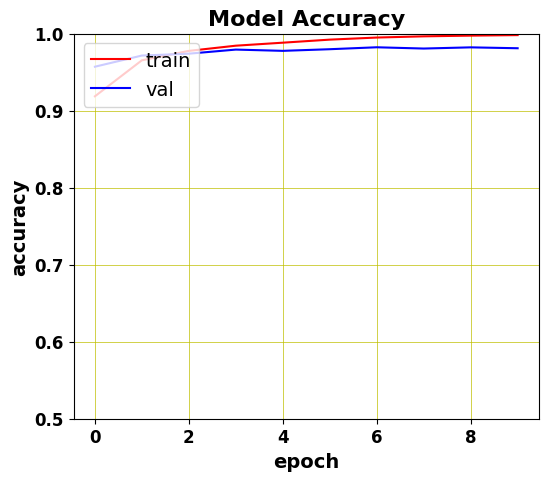

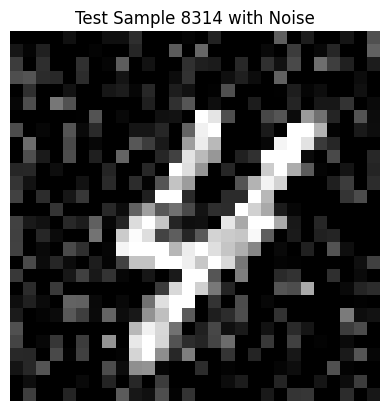

Accuracy over the test set: 
  69.09 %
1875/1875 [==============================] - 1s 620us/step
Layer 0 activation shape: (60000, 1000)
1875/1875 [==============================] - 1s 739us/step
Layer 1 activation shape: (60000, 200)
Layer 0: Gradient shape: (784, 1000)
Layer 1: Gradient shape: (1000, 200)
Total weights to consider: 984000
all_weights 984000


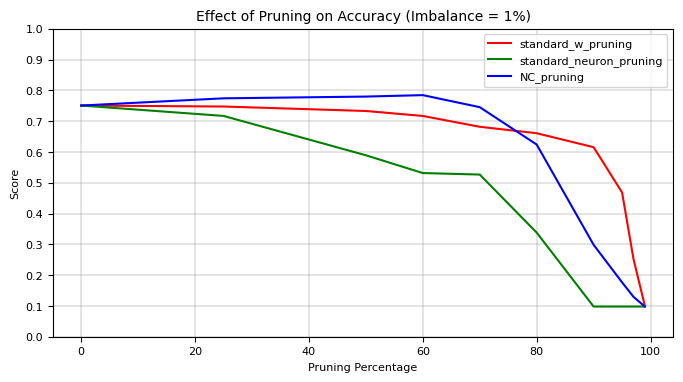

In [67]:
n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm,X_train_norm = preprocess(mnist,imbalance_factor=0.01)
model,save_best = train(n_features, n_classes, 'mnist.hdf5')
train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best)
X_test_noisy,Y_test_onehot = noise(mnist)
test(model, X_test_noisy, Y_test_onehot)
trained_model = load_model("mnist.hdf5")
total_no_layers = len(trained_model.layers)
neuron_pruning_scores = neuron_pruning(X_test_noisy, Y_test_onehot, total_no_layers, trained_model, 'mnist.hdf5')
weight_pruning_scores_nc = prune_weights_using_Sw(X_test_noisy, Y_test_onehot,X_train_norm, Y_train_onehot, K, trained_model, 'mnist.hdf5')
weight_pruning_scores = weigh_pruning(X_test_noisy, Y_test_onehot, K, trained_model, 'mnist.hdf5')

plots(weight_pruning_scores,neuron_pruning_scores, list(map(lambda x: x[1], weight_pruning_scores_nc)),'1%')

Number of input features (image pixels) :  784
Number of target classes (fashion categories) :  10


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 1000)              784000    
                                                                 
 dense_61 (Dense)            (None, 200)               200000    
                                                                 
 dense_62 (Dense)            (None, 10)                2000      
                                                                 
Total params: 986000 (3.76 MB)
Trainable params: 986000 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1580/1580 [==============================] - 4s 2ms/step - loss: 0.3191 - accuracy: 0.9124 - val_loss: 0.1769 - val_accuracy: 0.9497
Epoch 2/10
  76/1580 [>.............................] - ETA: 3s - loss: 0.1435 - accuracy: 0.9605

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1580/1580 [==============================] - 3s 2ms/step - loss: 0.1309 - accuracy: 0.9623 - val_loss: 0.1257 - val_accuracy: 0.9622
Epoch 3/10
1580/1580 [==============================] - 3s 2ms/step - loss: 0.0887 - accuracy: 0.9738 - val_loss: 0.1099 - val_accuracy: 0.9677
Epoch 4/10
1580/1580 [==============================] - 3s 2ms/step - loss: 0.0634 - accuracy: 0.9817 - val_loss: 0.0909 - val_accuracy: 0.9725
Epoch 5/10
1580/1580 [==============================] - 4s 2ms/step - loss: 0.0453 - accuracy: 0.9875 - val_loss: 0.0868 - val_accuracy: 0.9727
Epoch 6/10
1580/1580 [==============================] - 4s 2ms/step - loss: 0.0336 - accuracy: 0.9909 - val_loss: 0.0795 - val_accuracy: 0.9757
Epoch 7/10
1580/1580 [==============================] - 3s 2ms/step - loss: 0.0233 - accuracy: 0.9937 - val_loss: 0.0789 - val_accuracy: 0.9772
Epoch 8/10
1580/1580 [==============================] - 3s 2ms/step - loss: 0.0176 - accuracy: 0.9958 - val_loss: 0.0830 - val_accuracy: 0.9768
Epo

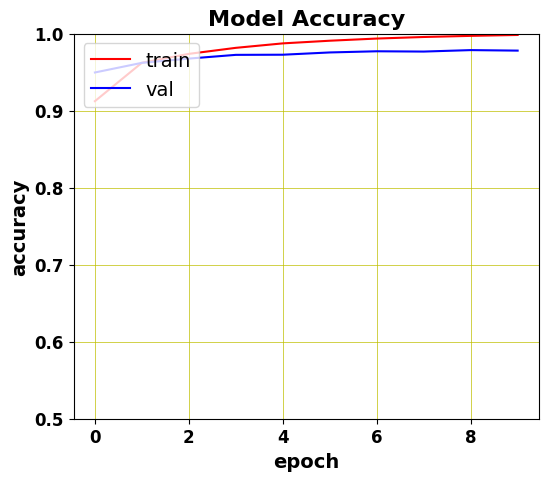

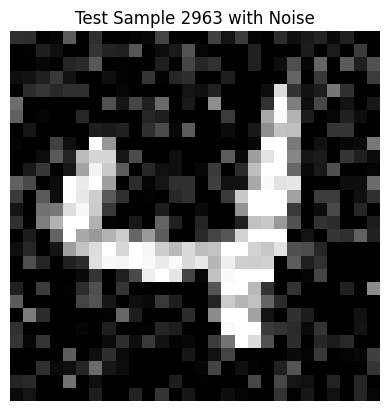

Accuracy over the test set: 
  82.83 %
1875/1875 [==============================] - 1s 567us/step
Layer 0 activation shape: (60000, 1000)
1875/1875 [==============================] - 1s 774us/step
Layer 1 activation shape: (60000, 200)
Layer 0: Gradient shape: (784, 1000)
Layer 1: Gradient shape: (1000, 200)
Total weights to consider: 984000
all_weights 984000


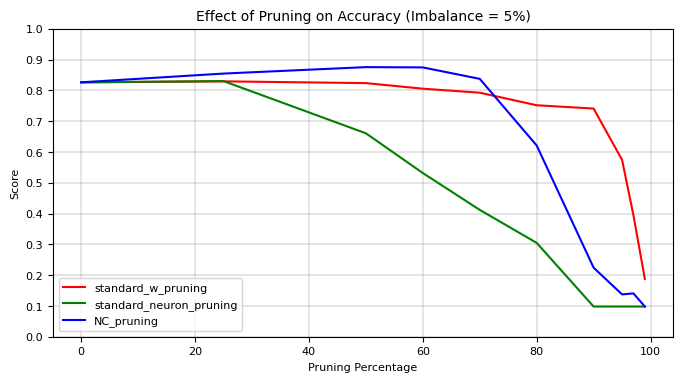

In [68]:
n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm,X_train_norm = preprocess(mnist,imbalance_factor=0.05)
model,save_best = train(n_features, n_classes, 'mnist.hdf5')
train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best)
X_test_noisy,Y_test_onehot = noise(mnist)
test(model, X_test_noisy, Y_test_onehot)
trained_model = load_model("mnist.hdf5")
total_no_layers = len(trained_model.layers)
neuron_pruning_scores = neuron_pruning(X_test_noisy, Y_test_onehot, total_no_layers, trained_model, 'mnist.hdf5')
weight_pruning_scores_nc = prune_weights_using_Sw(X_test_noisy, Y_test_onehot,X_train_norm, Y_train_onehot, K, trained_model, 'mnist.hdf5')
weight_pruning_scores = weigh_pruning(X_test_noisy, Y_test_onehot, K, trained_model, 'mnist.hdf5')

plots(weight_pruning_scores,neuron_pruning_scores, list(map(lambda x: x[1], weight_pruning_scores_nc)),'5%')

Number of input features (image pixels) :  784
Number of target classes (fashion categories) :  10


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 1000)              784000    
                                                                 
 dense_64 (Dense)            (None, 200)               200000    
                                                                 
 dense_65 (Dense)            (None, 10)                2000      
                                                                 
Total params: 986000 (3.76 MB)
Trainable params: 986000 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1615/1615 [==============================] - 4s 3ms/step - loss: 0.3300 - accuracy: 0.9122 - val_loss: 0.1895 - val_accuracy: 0.9475
Epoch 2/10
  70/1615 [>.............................] - ETA: 3s - loss: 0.1572 - accuracy: 0.9486

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1615/1615 [==============================] - 4s 3ms/step - loss: 0.1355 - accuracy: 0.9604 - val_loss: 0.1331 - val_accuracy: 0.9619
Epoch 3/10
1615/1615 [==============================] - 4s 3ms/step - loss: 0.0920 - accuracy: 0.9735 - val_loss: 0.1077 - val_accuracy: 0.9686
Epoch 4/10
1615/1615 [==============================] - 4s 3ms/step - loss: 0.0667 - accuracy: 0.9809 - val_loss: 0.0989 - val_accuracy: 0.9703
Epoch 5/10
1615/1615 [==============================] - 4s 3ms/step - loss: 0.0483 - accuracy: 0.9860 - val_loss: 0.0873 - val_accuracy: 0.9746
Epoch 6/10
1615/1615 [==============================] - 4s 3ms/step - loss: 0.0356 - accuracy: 0.9898 - val_loss: 0.0812 - val_accuracy: 0.9762
Epoch 7/10
1615/1615 [==============================] - 4s 3ms/step - loss: 0.0264 - accuracy: 0.9932 - val_loss: 0.0812 - val_accuracy: 0.9760
Epoch 8/10
1615/1615 [==============================] - 4s 3ms/step - loss: 0.0189 - accuracy: 0.9954 - val_loss: 0.0865 - val_accuracy: 0.9749
Epo

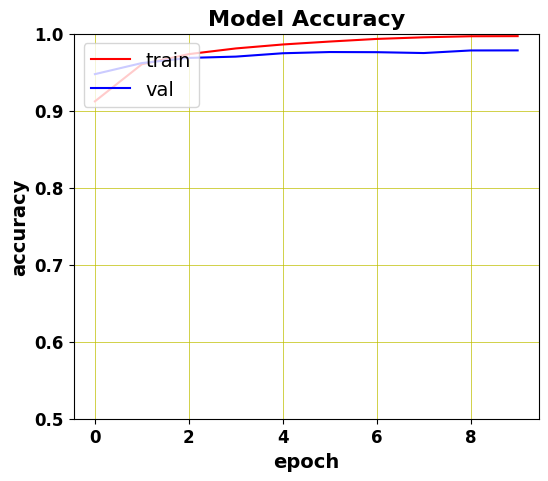

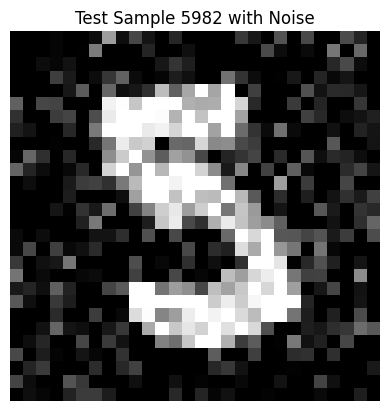

Accuracy over the test set: 
  89.44 %
1875/1875 [==============================] - 1s 691us/step
Layer 0 activation shape: (60000, 1000)
1875/1875 [==============================] - 2s 1ms/step
Layer 1 activation shape: (60000, 200)
Layer 0: Gradient shape: (784, 1000)
Layer 1: Gradient shape: (1000, 200)
Total weights to consider: 984000
all_weights 984000


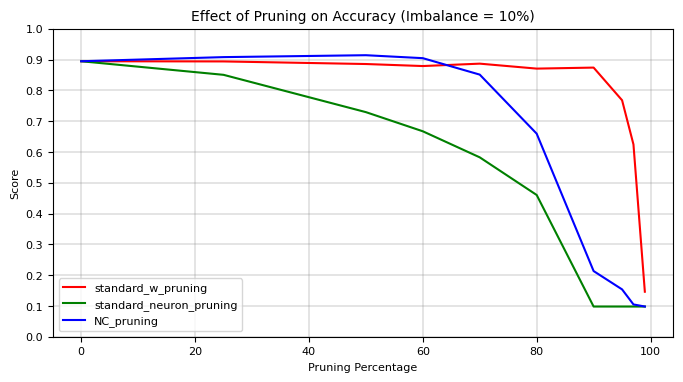

In [69]:
n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm,X_train_norm = preprocess(mnist,imbalance_factor=0.1)
model,save_best = train(n_features, n_classes, 'mnist.hdf5')
train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best)
X_test_noisy,Y_test_onehot = noise(mnist)
test(model, X_test_noisy, Y_test_onehot)
trained_model = load_model("mnist.hdf5")
total_no_layers = len(trained_model.layers)
neuron_pruning_scores = neuron_pruning(X_test_noisy, Y_test_onehot, total_no_layers, trained_model, 'mnist.hdf5')
weight_pruning_scores_nc = prune_weights_using_Sw(X_test_noisy, Y_test_onehot,X_train_norm, Y_train_onehot, K, trained_model, 'mnist.hdf5')
weight_pruning_scores = weigh_pruning(X_test_noisy, Y_test_onehot, K, trained_model, 'mnist.hdf5')

plots(weight_pruning_scores,neuron_pruning_scores, list(map(lambda x: x[1], weight_pruning_scores_nc)),'10%')